# Final Prediction: LightGBM

Train a GBM using K-fold CV and use the mean test prediction across the folds for the final submission.

## Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import shap
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Config

Number of CV folds.

In [2]:
NUM_FOLDS = 2

Make subsequent runs reproducible.

In [3]:
RANDOM_SEED = 2017
np.random.seed(RANDOM_SEED)

## Read Data

Load all features we extracted earlier.

In [4]:
df_train = pd.read_csv('../Final_Build/x_train.csv')
df_train.set_index('id', inplace=True)
df_train.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,q1_hash,q2_hash,q1_freq,q2_freq,PROB_BOTH_SHARE_TOPIC_0,PROB_BOTH_SHARE_TOPIC_1,PROB_BOTH_SHARE_TOPIC_2,PROB_BOTH_SHARE_TOPIC_3,PROB_BOTH_SHARE_TOPIC_4,PROB_BOTH_SHARE_TOPIC_5,...,NUM_WORDS(question1),NUM_WORDS(question2),NUM_CHARACTERS(question1),NUM_CHARACTERS(question2),min_kcore,max_kcore,common_neighbor_count,common_neighbor_ratio,min_freq,max_freq
id,,,,,,,,,,,,,,,,,,,,,
0,0,290457,1,2,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,14,12,66,57,0,0,0,0.0,1,2
1,1,16739,8,3,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,...,8,13,51,88,0,0,0,0.0,3,8
2,2,290458,2,1,0.000060,0.001250,0.076250,0.000060,0.000060,0.000060,...,14,10,73,59,0,0,0,0.0,1,2
3,3,290459,1,1,0.000125,0.010125,0.000125,0.000125,0.000125,0.007625,...,11,9,50,65,0,0,0,0.0,1,1
4,4,290460,3,1,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,13,7,76,39,0,2,0,0.0,1,3


In [5]:
df_test = pd.read_csv('../Final_Build/x_test.csv')
df_test.set_index('test_id', inplace=True)
df_test.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,q1_hash,q2_hash,q1_freq,q2_freq,PROB_BOTH_SHARE_TOPIC_0,PROB_BOTH_SHARE_TOPIC_1,PROB_BOTH_SHARE_TOPIC_2,PROB_BOTH_SHARE_TOPIC_3,PROB_BOTH_SHARE_TOPIC_4,PROB_BOTH_SHARE_TOPIC_5,...,NUM_WORDS(question1),NUM_WORDS(question2),NUM_CHARACTERS(question1),NUM_CHARACTERS(question2),min_kcore,max_kcore,common_neighbor_count,common_neighbor_ratio,min_freq,max_freq
test_id,,,,,,,,,,,,,,,,,,,,,
0,537361,2680914,1,1,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,11,14,57,68,0,0,0,0.0,1,1
1,537362,1258711,2,2,0.000083,0.001750,0.000083,0.036750,0.000083,0.000083,...,14,7,66,43,0,0,0,0.0,2,2
2,537363,2680915,1,1,0.002625,0.000125,0.000125,0.000125,0.000125,0.000125,...,14,6,60,29,0,0,0,0.0,1,1
3,537364,2680916,1,1,0.000417,0.000417,0.000417,0.008750,0.000417,0.000417,...,4,3,27,17,0,0,0,0.0,1,1
4,537365,2680917,1,1,0.122500,0.000278,0.000278,0.000278,0.000278,0.000278,...,4,6,32,30,0,0,0,0.0,1,1


In [6]:
assert all(df_train.columns == df_test.columns), 'Different cols in train and test'

Drop dodgy index columns

In [7]:
dodgy_cols = df_train.columns[['Unnamed:' in col for col in df_train.columns]].tolist()
df_train.drop(columns=dodgy_cols, inplace=True)
df_test.drop(columns=dodgy_cols, inplace=True)

In [8]:
X_train = df_train.values
X_test = df_test.values

In [9]:
y_train = pd.read_csv('../Final_Build/y_train.csv', header=None).values.reshape(-1, )

View feature summary.

In [10]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 48)
X test:  (2345796, 48)
y train: (404290,)


## Train models & compute test predictions from each fold

Calculate partitions.

In [11]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

Fit all folds.

In [12]:
cv_scores = []

In [13]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X_train[ix_train]
    X_fold_val = X_train[ix_val]

    y_fold_train = y_train[ix_train]
    y_fold_val = y_train[ix_val]
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }
    
    lgb_data_train = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_data_val = lgb.Dataset(X_fold_val, y_fold_val)    
    evals_result = {}
    
    model = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_val],
        evals_result=evals_result,
        verbose_eval=False,
    )
    
    fold_train_scores = evals_result['training'][lgb_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgb_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(
        fold_num + 1,
        len(fold_train_scores),
        fold_train_scores[-1],
        fold_val_scores[-1],
    ))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    pickle.dump(model, open('lgbm_model_fold_{}.pkl'.format(fold_num), 'wb'))

Fitting fold 1 of 2


/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1: 3384 rounds, training loss 0.246666, validation loss 0.314441

Fitting fold 2 of 2


/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2: 3573 rounds, training loss 0.245255, validation loss 0.312937

CPU times: user 28min 43s, sys: 36.3 s, total: 29min 19s
Wall time: 8min 32s


In [14]:
importances = pd.DataFrame({
    'column': list(df_train.columns),
    'importance': model.feature_importance(),
}).sort_values(by='importance', ascending=False)

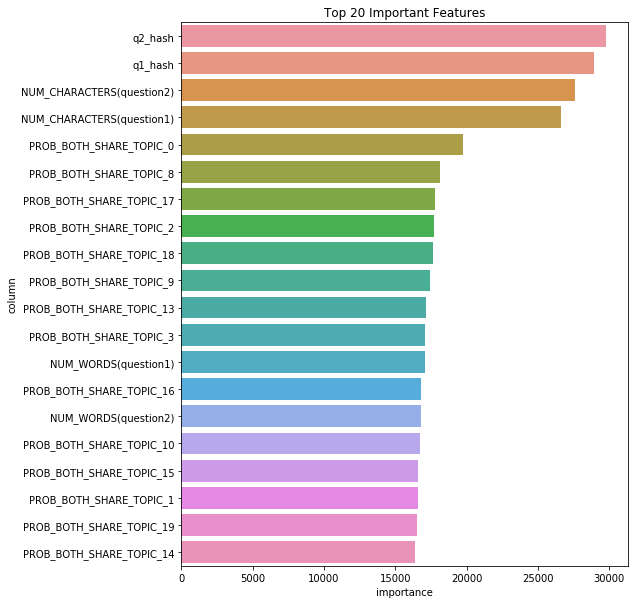

In [15]:
importances_to_plot = importances.iloc[:20, :]

fig, ax = plt.subplots(1, 1, figsize=[8, 10])
sns.barplot(x=importances_to_plot['importance'], y=importances_to_plot['column'], ax=ax)
ax.set_title('Top 20 Important Features')
plt.show()

In [16]:
y_test_pred = np.zeros((len(X_test), NUM_FOLDS))
for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    model = pickle.load(open('lgbm_model_fold_{}.pkl'.format(fold_num), 'rb'))
    y_test_pred[:, fold_num] = model.predict(X_test).reshape(-1)

Print full feature importance.

In [17]:
importances

,column,importance
1,q2_hash,29814
0,q1_hash,28963
41,NUM_CHARACTERS(question2),27601
40,NUM_CHARACTERS(question1),26633
4,PROB_BOTH_SHARE_TOPIC_0,19783
12,PROB_BOTH_SHARE_TOPIC_8,18162
21,PROB_BOTH_SHARE_TOPIC_17,17778
6,PROB_BOTH_SHARE_TOPIC_2,17744
22,PROB_BOTH_SHARE_TOPIC_18,17672
13,PROB_BOTH_SHARE_TOPIC_9,17450


In [18]:
final_cv_score = np.mean(cv_scores)

In [19]:
print('Final CV score:', final_cv_score)

Final CV score: 0.3136893193703356


## Generate submission

In [20]:
y_test = np.mean(y_test_pred, axis=1)

In [21]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [22]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

### Recalibrate predictions for a different target balance on test

Based on [Mike Swarbrick Jones' blog](https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/).

$\alpha = \frac{p_{test}}{p_{train}}$

$\beta = \frac{1 - p_{test}}{1 - p_{train}}$

$\hat{y}_{test}^{\prime} = \frac{\alpha \hat{y}_{test}}{\alpha \hat{y}_{test} + \beta(1 - \hat{y}_{test})}$

Training set balance is 36.92%, test set balance is ~16.5%.

In [23]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [24]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)

In [25]:
df_submission = df_submission[['test_id', 'is_duplicate']]

### Explore and save submission

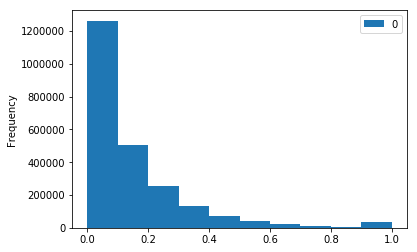

In [26]:
pd.DataFrame(y_test).plot.hist()

In [27]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 27401
Test mean prediction: 0.15031638403669756
Calibrated mean prediction: 0.07270760903390348


In [28]:
df_submission.to_csv(
    'submission.csv',
    header=True,
    float_format='%.8f',
    index=None,
)

In [29]:
df_submission.shape

(2345796, 2)

array([[0, 290457, 1, ..., 0.0, 1, 2],
       [1, 16739, 8, ..., 0.0, 3, 8],
       [2, 290458, 2, ..., 0.0, 1, 2],
       ...,
       [97, 43981, 1, ..., 0.0, 1, 3],
       [98, 290526, 1, ..., 0.0, 1, 1],
       [99, 290527, 2, ..., 0.0, 1, 2]], dtype=object)

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[:100])

In [76]:
shap.initjs()



shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[:1],feature_names = df_train.columns.tolist(),link ='logit')



In [77]:
shap.force_plot(explainer.expected_value, shap_values, X_train[:100], link ='logit', feature_names = df_train.columns.tolist())

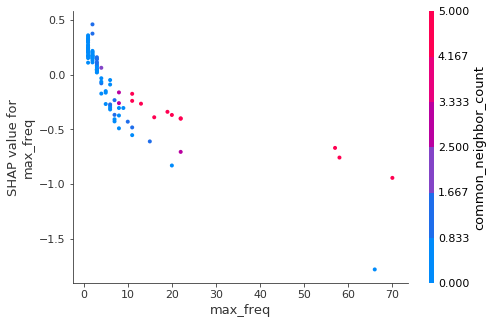

<Figure size 432x288 with 0 Axes>

In [74]:
shap.dependence_plot("max_freq", shap_values, X_train[:100], feature_names = df_train.columns.tolist())
plt.savefig("pdp.png")

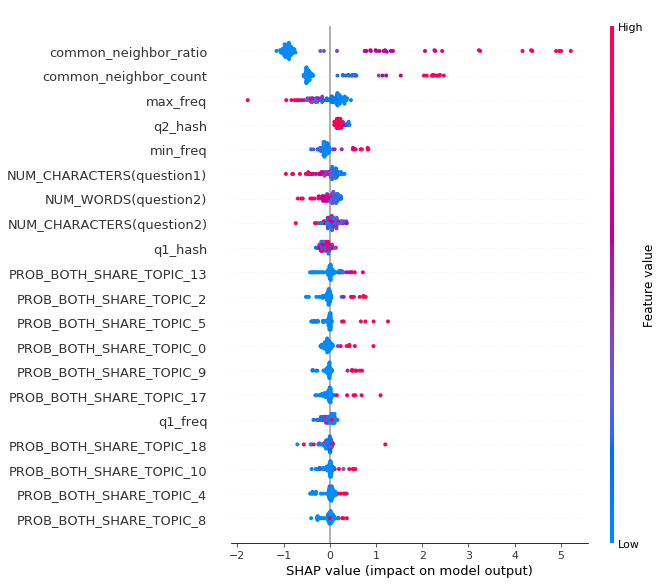

<Figure size 432x288 with 0 Axes>

In [75]:
shap.summary_plot(shap_values, X_train[:100],feature_names = df_train.columns.tolist())

plt.savefig("summary.png")